In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from scipy import sparse
from sklearn.cross_validation import train_test_split

/Users/michellehsu/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
y = pd.read_csv('triptype.csv', header= None)
X = sparse.load_npz('df_sparse_matrix.npz')

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size=0.2)

In [4]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(30564, 5275)
(7642, 5275)
(30564, 1)
(7642, 1)


In [40]:
#from scipy import sparse
#sparse.save_npz('X_train.npz', X_train)
#sparse.save_npz('X_test.npz', X_test)
#np.savetxt("y_train.csv", y_train, delimiter = ",")
#np.savetxt("y_test.csv", y_test, delimiter = ",")

## Naive Bayes

In [5]:
from sklearn.naive_bayes import MultinomialNB

In [6]:
nb = MultinomialNB()

In [7]:
nb.fit(X_train, y_train)
pred_nb = nb.predict(X_test)

In [236]:
error_nb = np.mean(pred_nb[:, np.newaxis] == y_test)
print(error_nb)

0    0.615415
dtype: float64


In [255]:
f1_score(y_test, pred_nb, average = "weighted")

0.60096752163939149

## Logistic Regression

### Logistic Regression Without tuning

In [9]:
from sklearn.linear_model import LogisticRegression

In [10]:
lr = LogisticRegression(random_state= 95828)
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)

In [237]:
error_lr = np.mean(pred_lr[:, np.newaxis] == y_test)
print(error_lr)

0    0.667103
dtype: float64


### Logistic Regression With tuning

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

In [13]:
parameters = {'C':[1e-2, 5e-2, 1e-1, 5e-1, 1, 10, 100]}
lr_cv = GridSearchCV(LogisticRegression(penalty='l1', random_state= 95828), cv = StratifiedKFold(n_splits=5, shuffle = True), param_grid = parameters, n_jobs = -1)
lr_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l1', random_state=95828, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [238]:
#Accuracy
pred_lr_cv = lr_cv.predict(X_test)
error_lr_cv = np.mean(pred_lr_cv[:, np.newaxis] == y_test)
print(error_lr_cv)

0    0.671029
dtype: float64


In [253]:
#F1-score
from sklearn.metrics import f1_score
f1_score(y_test, pred_lr_cv, average = "weighted")

0.65892908139949657

In [351]:
test_label= list(set(y_test[0]))
test_label = [i.astype(int)for i in test_label]

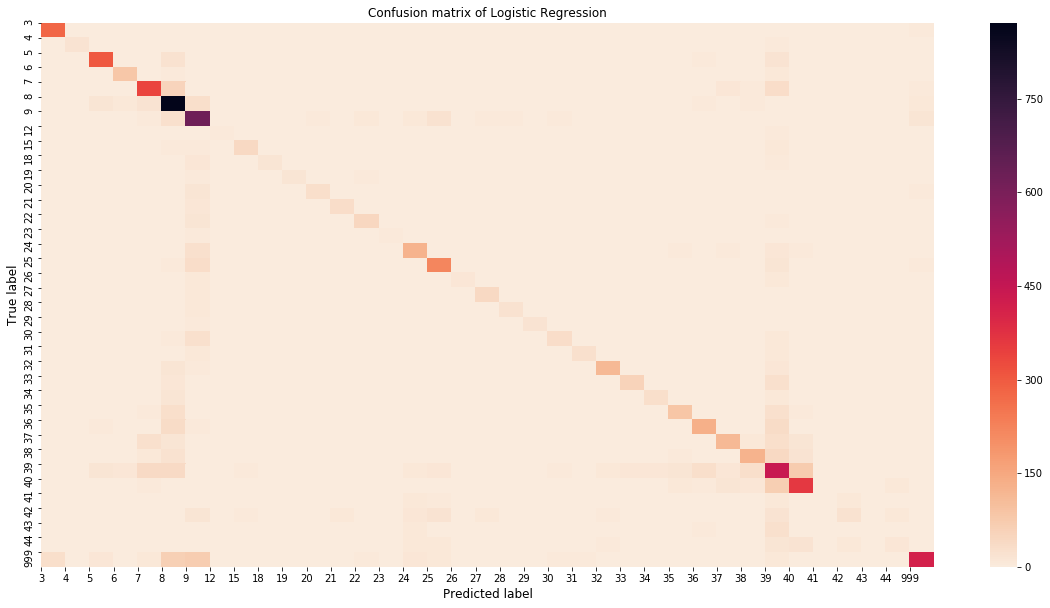

In [354]:
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(20,10))
lr_cm = confusion_matrix(y_test, pred_lr_cv)
sns.heatmap(lr_cm, cmap='rocket_r')
axis_font = {'size':'12'}
plt.ylabel('True label', **axis_font)
plt.xlabel('Predicted label', **axis_font)
plt.xticks(np.arange(37), test_label)
plt.yticks(np.arange(37), test_label)
plt.title('Confusion matrix of Logistic Regression', **axis_font)
plt.savefig("lr cm", dpi = 300)
plt.show()

---------

### ROC curve

In [25]:
from sklearn.multiclass import OneVsRestClassifier

In [102]:
y_class= list(set(y_train[0]))

In [103]:
# Binarize the output
from sklearn.preprocessing import label_binarize
y_binary = label_binarize(y, classes= y_class)
n_classes = y_binary.shape[1]

In [104]:
X_train_bi, X_test_bi, y_train_bi, y_test_bi = train_test_split(X, y_binary, test_size=.2,
                                                    random_state=95865)

In [107]:
classifier = OneVsRestClassifier(LogisticRegression(penalty='l1', random_state= 95828, C=1))
y_score = classifier.fit(X_train_bi, y_train_bi).decision_function(X_test_bi)

In [327]:
y_c = [i.astype(int)for i in y_class]

In [168]:
# Compute ROC curve and ROC area for each class
from sklearn.metrics import roc_curve, auc
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(38):
    fpr[i], tpr[i], _ = roc_curve(y_test_bi[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bi.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

In [170]:
from collections import Counter

In [223]:
values = []
for k, v in roc_auc.items():
    values.append(v)

In [228]:
values = np.array(values)
idx = list(np.argsort(values)[::-1])

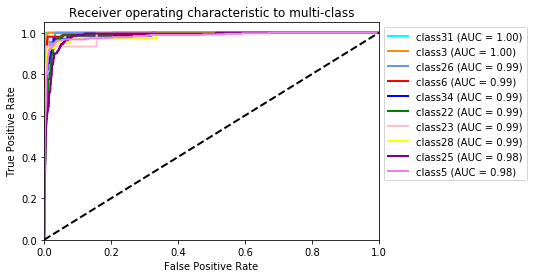

In [232]:
from scipy import interp
from itertools import cycle
# Compute macro-average ROC curve and ROC area
# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

plt.figure()
colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'blue', 'green', 'pink', 'yellow', 'purple', 'violet'])
for i, color in zip(idx[0:10], colors):
    j = y_c[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='class{0} (AUC = {1:0.2f})'
             ''.format(j, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic to multi-class')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()

### Precision-Recall Curve for Logistic Regression

In [256]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score

In [329]:
precision_lr = dict()
recall_lr = dict()
average_precision_lr = dict()

for i in range(n_classes):
    precision_lr[i],recall_lr[i],_ = precision_recall_curve(y_test_bi[:, i], y_score[:, i])
    average_precision_lr[i] = average_precision_score(y_test_bi[:, i], y_score[:, i])

In [338]:
counts = [i.astype(int )for i in y[0]]
type_count = dict((x,counts.count(x)) for x in set(counts))
import operator
sorted_type = sorted(type_count.items(), key=operator.itemgetter(1), reverse = True)

In [340]:
top10_trip = []
for i in range(len(sorted_type[0:10])):
    top10_trip.append(sorted_type[0:10][i][0])

In [341]:
idx = {}
for i in range(len(y_c)):
    if y_c[i] in top10_trip:
        idx[i] = y_c[i]

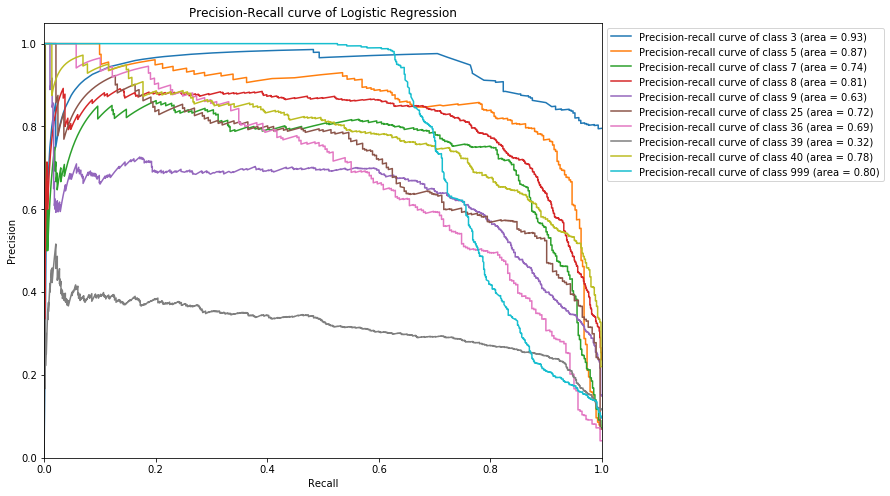

In [349]:
# plot precision recall curve for each class
plt.figure(figsize=(10,8))
for i in idx.keys():
    plt.plot(recall_lr[i],precision_lr[i],label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(idx[i], average_precision_lr[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Precision-Recall curve of Logistic Regression')
plt.savefig('PR lg',dpi = 300, bbox_inches = 'tight')

## SVM

### SVM Without tuning

In [234]:
from sklearn.svm import LinearSVC

In [235]:
svc = LinearSVC(random_state= 95828)
svc.fit(X_train, y_train)
pred_svc = svc.predict(X_test)

In [239]:
error_svc = np.mean(pred_svc[:, np.newaxis] == y_test)
print(error_svc)

0    0.634781
dtype: float64


### SVM With tuning

In [251]:
param_grid={'C': [0.01, 0.1, 1, 10, 100]}
svc_cv = GridSearchCV(LinearSVC(penalty='l2', random_state= 95828), cv = StratifiedKFold(n_splits=5, shuffle = True), param_grid = parameters, n_jobs = -1)
svc_cv.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=True),
       error_score='raise',
       estimator=LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=95828, tol=0.0001,
     verbose=0),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'C': [0.01, 0.05, 0.1, 0.5, 1, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [252]:
pred_svc_cv = svc_cv.predict(X_test)
error_svc_cv = np.mean(pred_svc_cv[:, np.newaxis] == y_test)
print(error_svc_cv)

0    0.670505
dtype: float64


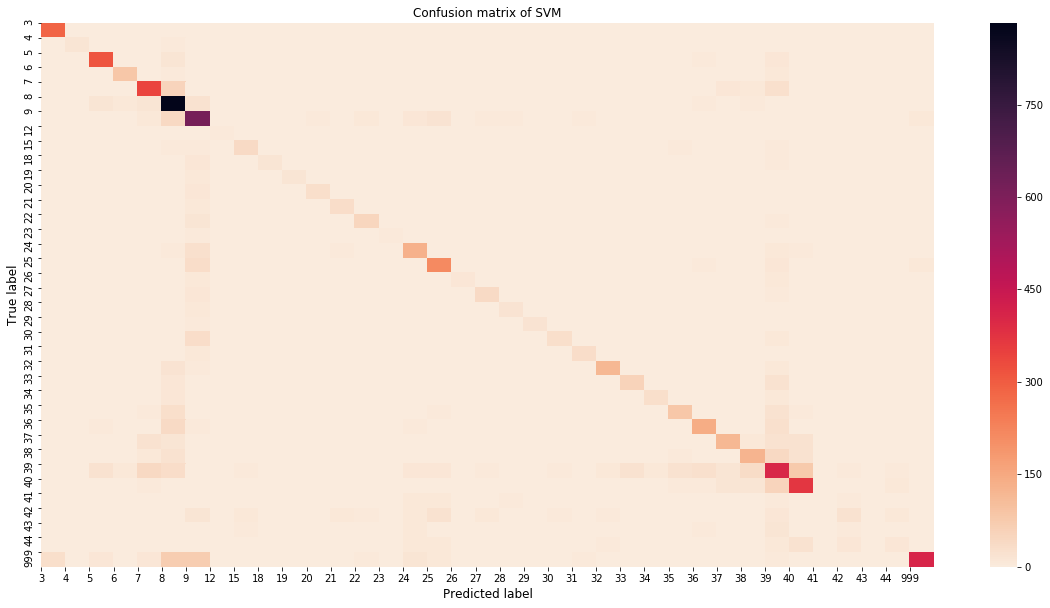

In [355]:
plt.figure(figsize=(20,10))
svm_cm = confusion_matrix(y_test, pred_svc_cv)
sns.heatmap(svm_cm, cmap='rocket_r')
plt.ylabel('True label', **axis_font)
plt.xlabel('Predicted label', **axis_font)
plt.xticks(np.arange(37), test_label)
plt.yticks(np.arange(37), test_label)
plt.title('Confusion matrix of SVM',**axis_font)
plt.savefig("SVM cm", dpi = 300)
plt.show()

In [254]:
#F1 score
f1_score(y_test, pred_svc_cv, average = "weighted")

0.65662254600316938

### Precision-Recall Curve for SVM

In [320]:
precision_svm = dict()
recall_svm = dict()
average_precision_svm = dict()

for i in range(n_classes):
    precision_svm[i],recall_svm[i],_ = precision_recall_curve(y_test_bi[:, i], y_score[:, i])
    average_precision_svm[i] = average_precision_score(y_test_bi[:, i], y_score[:, i])

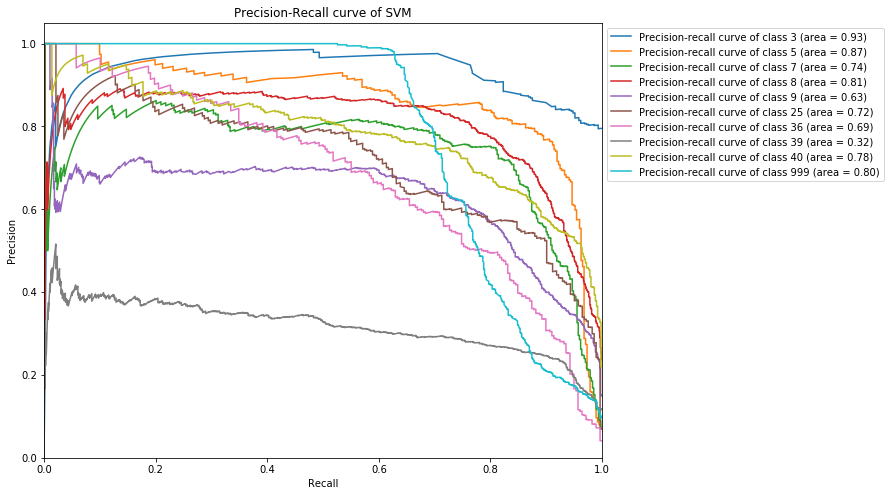

In [348]:
# plot precision recall curve for each class
plt.figure(figsize=(10,8))
for i in idx.keys():
    plt.plot(recall_svm[i],precision_svm[i],label='Precision-recall curve of class {0} (area = {1:0.2f})'
                   ''.format(idx[i], average_precision_svm[i]))
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend(bbox_to_anchor=(1, 1))
plt.title('Precision-Recall curve of SVM')
plt.savefig('PR svm',dpi = 300, bbox_inches = 'tight')